In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import zipfile
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import pylab

In [ ]:
split=0.2
seed=19260817
batch_size=256
img_size=(224,224)

train_ds = keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/dogs-vs-cats/training',
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True,
    seed=seed,
    validation_split=split,
    subset='training',
)
val_ds = keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/dogs-vs-cats/training',
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True,
    seed=seed,
    validation_split=split,
    subset='validation',
)

Found 205 files belonging to 2 classes.
Using 164 files for training.
Found 205 files belonging to 2 classes.
Using 41 files for validation.


<ipython-input-3-6046dea0c6eb>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 4,i+1)


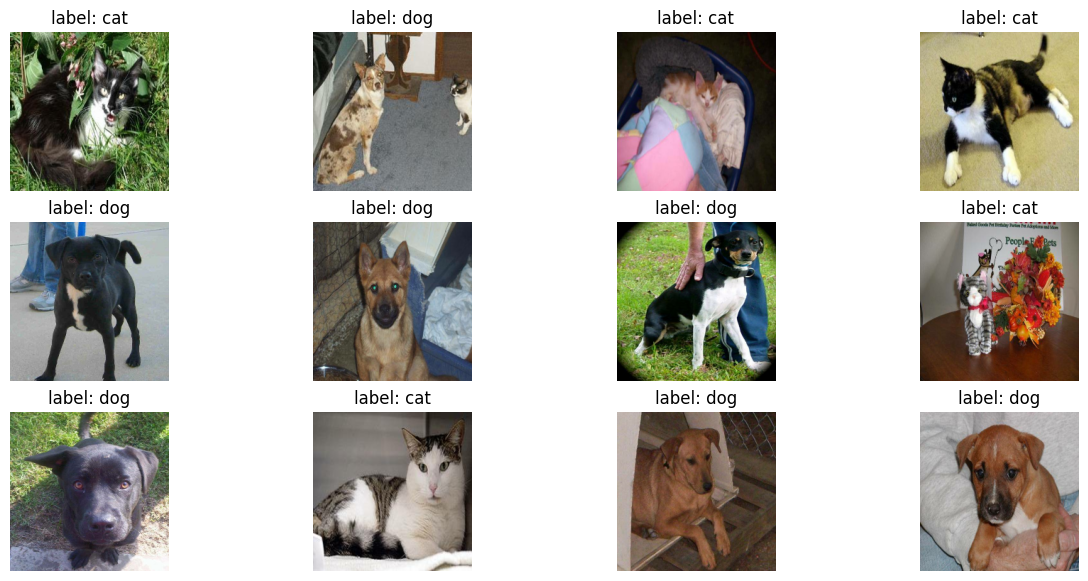

In [ ]:
label_names={0:'cat',1:'dog'}

fig, ax = plt.subplots(figsize=(15, 7))
for img, label in train_ds.take(1):
    for i in range(12):
        plt.subplot(3, 4,i+1)
        plt.imshow(img.numpy()[i]/255)
        plt.axis("off")
        plt.title("label: "+label_names[label.numpy()[i]])
        #rint("label:", label.numpy()[i])
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_history(history,title=''):
    if title!='':
        title+=' '
    #Ploting the Loss and Accuracy Curves
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16,6))
    #Loss
    sns.lineplot(data = history.history['loss'], label = 'Training Loss', ax = ax[0])
    sns.lineplot(data = history.history['val_loss'], label = 'Validation Loss', ax = ax[0])
    ax[0].legend(loc = 'upper right')
    ax[0].set_title(title+'Loss')
    #Accuracy
    sns.lineplot(data = history.history['accuracy'], label = 'Training Accuracy', ax = ax[1])
    sns.lineplot(data = history.history['val_accuracy'], label = 'Validation Accuracy', ax = ax[1])
    ax[1].legend(loc = 'lower right')
    ax[1].set_title(title+'Accuracy')

In [ ]:
data_augmentation = keras.Sequential(
    [
        #layers.RandomFlip("horizontal"),
        #layers.RandomRotation(0.2),
        #layers.RandomTranslation(0.14,0.14),
        #layers.RandomZoom(0.2),
        #layers.RandomContrast(0.2),
    ]
)

In [ ]:
CB = [
            keras.callbacks.ModelCheckpoint(
            filepath="fine_tuning.keras",
            save_best_only=True,
            monitor="val_loss"),

            keras.callbacks.EarlyStopping(
            monitor='val_loss',
            min_delta=0.0005,
            patience=10)
]

In [ ]:
vgg16_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    #weights=None,
    include_top=False)

#vgg16_base.trainable = True
vgg16_base.trainable = False

print("This is the number of trainable weights "
      "before freezing the conv base:", len(vgg16_base.trainable_weights))

vgg16_base.summary()

58889256/58889256 [==============================] - 0s 0us/step
This is the number of trainable weights before freezing the conv base: 0
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   

In [ ]:
inputs = keras.Input(shape=img_size+(3,))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = vgg16_base(x)
x = layers.Flatten()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256,activation='softplus')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256,activation='softplus')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256,activation='softplus')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256,activation='softplus')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(2, activation="softmax")(x)
vgg16_model = keras.Model(inputs, outputs)
vgg16_model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
vgg16_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     multiple                  0         
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0     

In [ ]:
from keras.callbacks import Callback

class MyCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Your custom callback logic here
        pass

# Instantiate your custom callback
my_callback = MyCustomCallback()

# Train the VGG16 model with the custom callback
history_vgg16 = vgg16_model.fit(
    train_ds,
    epochs=5,
    validation_data=val_ds,
    callbacks=[my_callback]  # Pass the callback as a list
)



Epoch 1/5
1/1 [==============================] - 2s 2s/step - loss: 0.7664 - accuracy: 0.6829 - val_loss: 0.3792 - val_accuracy: 0.9024
Epoch 2/5
1/1 [==============================] - 2s 2s/step - loss: 0.5251 - accuracy: 0.8232 - val_loss: 0.3190 - val_accuracy: 0.9024
Epoch 3/5
1/1 [==============================] - 2s 2s/step - loss: 0.4174 - accuracy: 0.8476 - val_loss: 0.2716 - val_accuracy: 0.9024
Epoch 4/5
1/1 [==============================] - 2s 2s/step - loss: 0.3091 - accuracy: 0.8476 - val_loss: 0.2411 - val_accuracy: 0.9268
Epoch 5/5
1/1 [==============================] - 2s 2s/step - loss: 0.3921 - accuracy: 0.8841 - val_loss: 0.2045 - val_accuracy: 0.9268


In [ ]:
plot_history(history_vgg16,'vgg16')

In [ ]:
vgg16_test=vgg16_model.evaluate(val_ds)


1/1 [==============================] - 1s 521ms/step - loss: 0.2045 - accuracy: 0.9268


In [ ]:
import os
test_filenames = os.listdir("/content/drive/MyDrive/dogs-vs-cats/testing/test1")
test_df = pd.DataFrame({
    'id': test_filenames
})
nb_samples = test_df.shape[0]
nb_samples

51

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, load_img
test_gen = ImageDataGenerator()
test_generator = test_gen.flow_from_dataframe(
    test_df,
    "/content/drive/MyDrive/dogs-vs-cats/testing/test1",
    x_col='id',
    y_col=None,
    class_mode=None,
    target_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

Found 50 validated image filenames.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="id". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
# Update the callback to include custom logic if needed
class MyCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Your custom callback logic here
        pass

# Train the VGG16 model with the custom callback
history_vgg16 = vgg16_model.fit(
    train_ds,
    epochs=5,
    validation_data=val_ds,
    callbacks=[my_callback]  # Pass the callback as a list
)

Epoch 1/5
1/1 [==============================] - 2s 2s/step - loss: 0.3332 - accuracy: 0.8902 - val_loss: 0.1752 - val_accuracy: 0.9268
Epoch 2/5
1/1 [==============================] - 2s 2s/step - loss: 0.2151 - accuracy: 0.9207 - val_loss: 0.1597 - val_accuracy: 0.9512
Epoch 3/5
1/1 [==============================] - 2s 2s/step - loss: 0.0954 - accuracy: 0.9756 - val_loss: 0.1514 - val_accuracy: 0.9512
Epoch 4/5
1/1 [==============================] - 2s 2s/step - loss: 0.0458 - accuracy: 1.0000 - val_loss: 0.1453 - val_accuracy: 0.9512
Epoch 5/5
1/1 [==============================] - 2s 2s/step - loss: 0.0788 - accuracy: 0.9695 - val_loss: 0.1421 - val_accuracy: 0.9756


In [ ]:

# Ensure test_df contains exactly 50 rows
test_df = test_df[:50]

1/1 [==============================] - 0s 290ms/step


<ipython-input-39-899d2ab50bcf>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['labels'] = np.argmax(predict, axis=-1)
<ipython-input-39-899d2ab50bcf>:14: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 4, i+1)


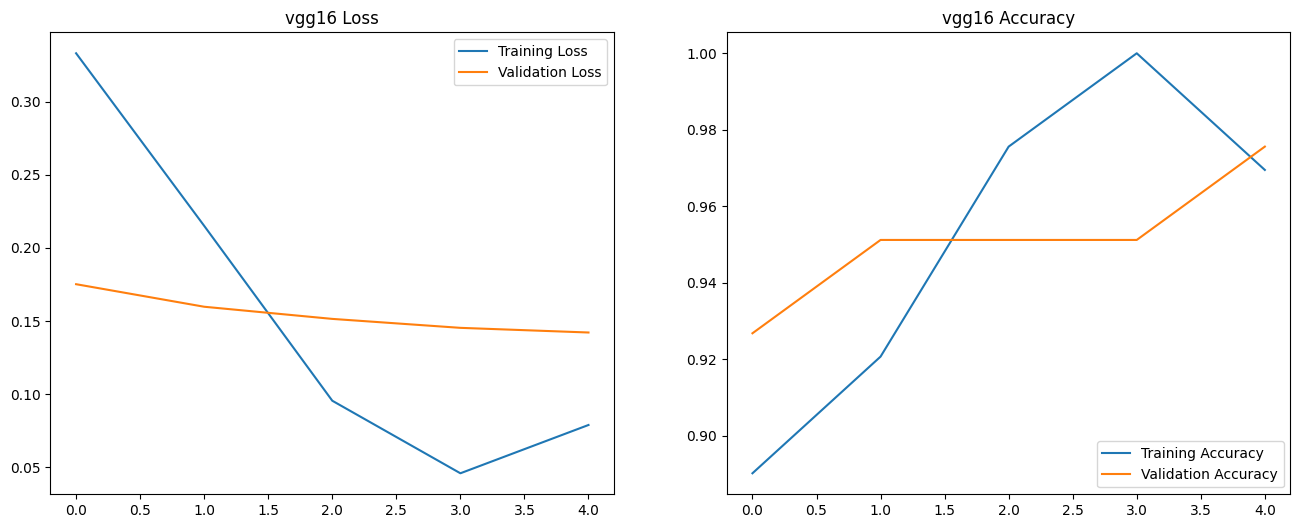

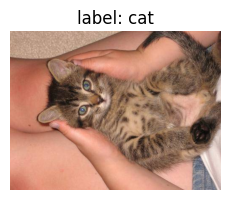

In [ ]:
# Plot history
plot_history(history_vgg16, 'vgg16')

# Predict on test data
predict = vgg16_model.predict(test_generator)

# Process predictions and create dataframe
test_df['labels'] = np.argmax(predict, axis=-1)

# Plot some sample predictions
label_names = {0: 'cat', 1: 'dog'}
fig, ax = plt.subplots(figsize=(15, 7))
for index, row in test_df.sample(12).iterrows():
    plt.subplot(3, 4, i+1)
    img = plt.imread('/content/drive/MyDrive/dogs-vs-cats/testing/test1/' + row['id'])
    plt.imshow(img)
    plt.axis("off")
    plt.title("label: " + label_names[row['labels']])
plt.show()

In [ ]:
test_df.set_index('id')
test_df.to_csv('submission.csv',index=False)